In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
import copy

In [ ]:
import json
import os
import math
import librosa, librosa.display

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

## Funciones auxiliares

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
def predicted_labels(predictions):
    pred_l = []
    i = 0
    j = 0
    for prediction in predictions:
        i = 0
        j = 0
        aux = None
        max = None
        for prob in prediction:
            aux = prob
            if i == 0:
                max = aux
                j = i
            else:
                if aux > max:
                    max = aux
                    j = i
            i +=1
        pred_l.append(j)
    return np.array(pred_l)

In [ ]:
def show_confusion_matrix(y, labels, predict):
  # Compute confusion matrix and normalize
  n = len(labels)
  plt.figure(figsize=(n,n))
  confusion = confusion_matrix(y,predict)
  confusion_normalized = confusion / confusion.sum(axis=1)
  axis_labels = range(n)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()

In [ ]:
def display_matriz_confusion(mcs):
    n = len(mcs)
    s = 5
    if n%s == 0:
        m = int(n/s)
    else:
        m = int(n/s)+1
    fig, axes = plt.subplots(nrows=m, ncols=s)
    fig.set_size_inches(20, 12)
    for mc, ax in zip(mcs, axes.flatten()):
        disp = ConfusionMatrixDisplay(confusion_matrix=mc)
        disp.plot(ax=ax,cmap='Blues')
    axes[-1,-1].axis('off')
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()

In [ ]:

def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()

## Download Data

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/data/"
JSON_PATH = "data_complete(1).json"

In [ ]:
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

Este metodo es para guardar el data que se encuentra en el folder genres_original, el cual contiene 10 subdirectorios con el nombre de cada genero musical y cada uno de estos subdirectorios contiene 100 archivos .wav que contienen 30 seg. de muestra de audio de canciones que son del genero del subdirectorio donde se estan.

Aparte de esto con num_segments se divide cada audio en num_segments, es decir si num_segments$=5$, entonces se dividira cada audio en audios de 6 seg, porque cada uno es de 30 seg en total. Esto es para aumentar el dataset num_segments veces.

Todo el data se guarda en un .json el cual contendra como raw data el mfcc de cada audio, el mffc consta de parametros como num_mfcc, n_fft y hop_length.

In [ ]:

def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along with genre labels.
        """

    # dictionary to store data
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

       
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio by genre dir
            for f in filenames:

		# load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # pproceso para dividir los audios
                for d in range(num_segments):

                    # inicio y fin para dividir los audios en num_segments.
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
     

# Music Genre Classification

**DESCRIPCIÓN DEL PROBLEMA**

En general, los seres humanos somos buenos para distinguir el título de una canción, el artista que la canta, e incluso su género, escuchando apenas un fragmento de la canción. Esta capacidad ha tratado de ser emulada utilizando redes neuronales. Un ejemplo de su uso es la aplicación móbil Shazam, la cual puede determinar el título y el autor de una canción a partir de un fragmento. Así, este trabajo busca clasificar distintos extractos de pistas musicales de acuerdo a su género musical específico.  

**Descripción del Dataset**

El Dataset con el que se trabaja es el GTZAN, elaborado por G. Tzanetakis y P. Cook. El Dataset consiste en 10 conjuntos de 100 pistas de audio cada una, con una duración de 30 segundos por pista, de modo que son 1000 pistas de audio en total. Cada conjunto se encuentra asociado a uno de los siguientes 10 géneros musicales: Blues, Clásica, Country, Disco, Hip-Hop, Jazz, Metal, Pop, Reggae y Rock. 

## PROCESAMIENTO DE LOS ARCHIVOS





Para entender de manera general cómo se van a procesar las pistas de audio del dataset GTZAN, se muestra un ejemplo con una sola pista de audio. 

In [ ]:
path_example = path + "genres_original/disco/disco.00093.wav"

In [ ]:
#se carga un archivo de la sub-carpeta de música disco
ejemplo = path_example

In [ ]:
# se carga el archivo con una frecuencia de muestreo de 22050 
signal, sample_rate = librosa.load(ejemplo)

In [ ]:
FIG_SIZE = (16,8)

La frecuencia de muestreo es el número de muestras por unidad de tiempo que se toman de una señal continua para producir una señal discreta, durante el proceso necesario de conversión. A continuación se grafica lo obtenido anteriormente como una forma de onda. 

In [ ]:
plt.figure(figsize= (14,8))
librosa.display.waveplot(signal, sample_rate, alpha = 0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

Dado que la forma de conversión obtenida anteriormente no es la más óptima para trabajar las pistas de audio, se realiza un proceso conocido como transformada de Fourier, en el cual se pasa del dominio de tiempo a un dominio de frecuencias. Se muestra la gráfica respectiva a dicha conversión. 

In [ ]:
#transformada de Fourier
fft = np.fft.fft(signal)
#magnitudes de los fft
spectrum = np.abs(fft)
f = np.linspace(0, sample_rate, len(spectrum))

In [ ]:
plt.figure(figsize= FIG_SIZE)
plt.plot(f, spectrum, alpha=0.5)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power Spectrum")


Ya que se mostró el papel que juega la transformada de fourier en el procesamiento de las señales para tener una representación más óptima de los datos, se obtienen los MFCCs (Ceoficientes Cepstrales en las Frecuencias de Mel), los cuales permiten extraer los componentes que son adecuados para idenficar contenido relevante. El cálculo de los MFFCs, básicamente consiste en separar la pista en pequeños tramos, aplicar la transformada de fourier discreta a cada uno, aplicar el banco de filtros de la Escala Mel, tomar el logaritmo de las energías de frencuencia de mel obtenidas anteriormente y finalmente aplicar la transformada de coseno discreta. Se muestran los MFCCs en escala de decíbeles. 

La producción de sonidos puede entenderse como la composición de dos elementos: la fuente y el filtrado. De modo que la señal que escuchamos es el producto de la convolución de ambas señales (la de la fuente y el filtrado).  
Es por esto que al calcular los MFCCs lo que se hace es separar (con la transformada de Fourier) estas dos señales y hacer desaparecer (con los filtros de la Escala Mel) la influencia de la fuente.

In [ ]:
# número de muestras
hop_length = 512
# número de muestras
n_fft = 2048 # num de muestras por ventana
# Se calculan 13 MFCCs
MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

In [ ]:
plt.figure(figsize= FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length= hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

La función que se definió anteriormente (*save_mfcc*) se encarga básicamente de obtener los MFCCs de cada una de las pistas de audio. 

In [ ]:
save_mfcc(path+"genres_original", JSON_PATH, num_segments=1)

## Convolutional Neural Network

Aqui se presenta una red convolutional para clasificar los mfcc de cada audio segun su genero. Se hace uso de una convolucional porque un mfcc es un espectrograma y esto es muy parecido a trabajar con imagenes, además el pasar el audio en crudo a su espectrogramam reduce mucho el tamaño de los datos.

### Dataset

In [ ]:
data_path = path + "data_10.json"

In [ ]:
def load_data(data_path):

    with open(data_path, "r") as f:
        data = json.load(f)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

In [ ]:
X, Y = load_data(data_path)

Data succesfully loaded!


In [ ]:
X.shape

(9976, 130, 13)

In [ ]:
#  Etiquetas para cada genero musical.

labels = np.unique(Y)
labels = np.sort(labels)
labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [ ]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.2)

### Pipeline

Necesitamos añadir la dimensión del canal para que sea una imagen.

In [ ]:
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
X_train.shape

(5586, 130, 13, 1)

### Training

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [ ]:
# build the CNN
model_cnn = keras.Sequential()

# 1st conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
model_cnn.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
model_cnn.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# flatten output y entra a una DNN (Deep Neural Network)
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(1920, activation='relu',kernel_regularizer='l2'))
model_cnn.add(keras.layers.Dropout(0.4))
model_cnn.add(keras.layers.Dense(960, activation='relu',kernel_regularizer='l2'))
model_cnn.add(keras.layers.Dropout(0.3))
model_cnn.add(keras.layers.Dense(480, activation='relu',kernel_regularizer='l2'))
model_cnn.add(keras.layers.Dropout(0.3))
model_cnn.add(keras.layers.Dense(240, activation='relu',kernel_regularizer='l2'))
# output layer
model_cnn.add(keras.layers.Dense(11, activation='softmax'))

In [ ]:
model_cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 6, 32)        0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 64, 6, 32)        128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                      

In [ ]:
history = model_cnn.fit(X_train, Y_train, validation_data=(X_validation, Y_validation), batch_size=32, epochs=50)

Epoch 1/50
175/175 [==============================] - 20s 112ms/step - loss: 1.7672 - accuracy: 0.4076 - val_loss: 1.8428 - val_accuracy: 0.3565
Epoch 2/50
175/175 [==============================] - 13s 77ms/step - loss: 1.2824 - accuracy: 0.5494 - val_loss: 1.1609 - val_accuracy: 0.5684
Epoch 3/50
175/175 [==============================] - 13s 73ms/step - loss: 1.0683 - accuracy: 0.6255 - val_loss: 1.1019 - val_accuracy: 0.5999
Epoch 4/50
175/175 [==============================] - 13s 73ms/step - loss: 0.9568 - accuracy: 0.6651 - val_loss: 1.0276 - val_accuracy: 0.6228
Epoch 5/50
175/175 [==============================] - 13s 74ms/step - loss: 0.8650 - accuracy: 0.7025 - val_loss: 0.9759 - val_accuracy: 0.6349
Epoch 6/50
175/175 [==============================] - 13s 73ms/step - loss: 0.7930 - accuracy: 0.7265 - val_loss: 0.9499 - val_accuracy: 0.6571
Epoch 7/50
175/175 [==============================] - 13s 73ms/step - loss: 0.7301 - accuracy: 0.7488 - val_loss: 1.0334 - val_accuracy

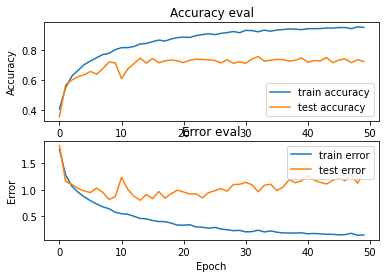

In [ ]:
# plot accuracy and error as a function of the epochs
plot_history(history)

### Results

In [ ]:
prediction = predicted_labels(model_cnn.predict(X_test))

94/94 [==============================] - 2s 20ms/step


In [ ]:
print(classification_report(Y_test,prediction))

              precision    recall  f1-score   support

           0       0.73      0.51      0.60       298
           1       0.79      0.52      0.62       292
           2       0.56      0.86      0.68       302
           3       0.79      0.76      0.77       312
           4       0.51      0.54      0.52       302
           5       0.86      0.58      0.70       317
           6       0.73      0.83      0.78       286
           7       0.84      0.80      0.82       286
           9       0.76      0.91      0.83       293
          10       0.86      0.95      0.90       305

    accuracy                           0.73      2993
   macro avg       0.74      0.73      0.72      2993
weighted avg       0.74      0.73      0.72      2993



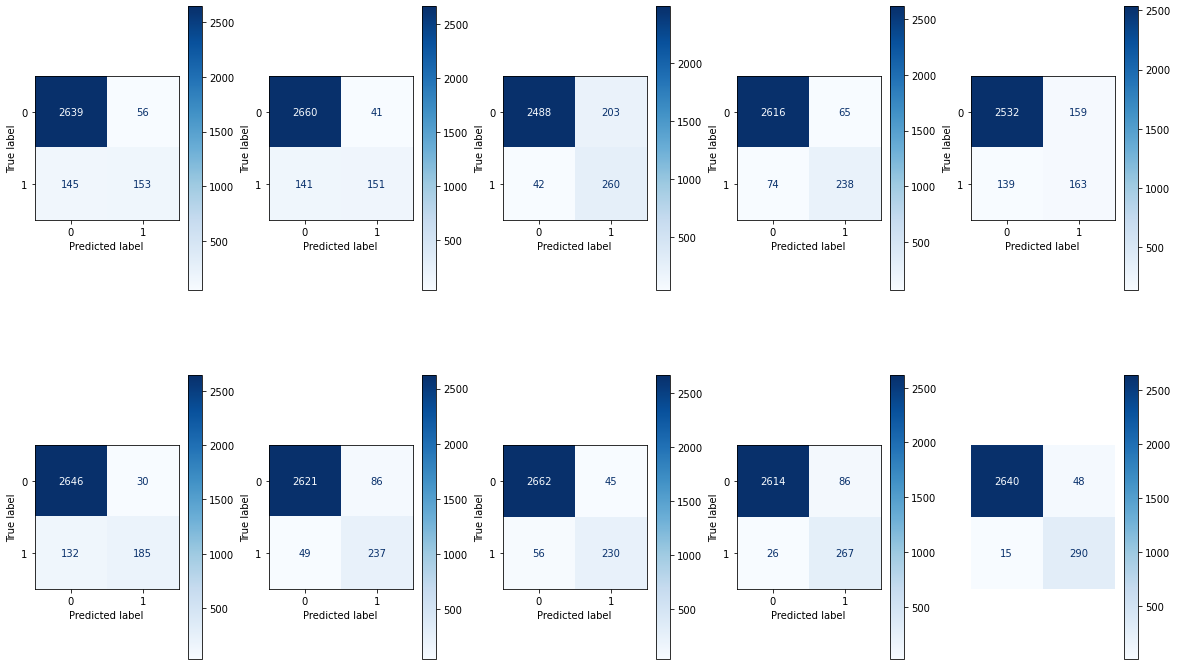

In [ ]:
display_matriz_confusion(multilabel_confusion_matrix(Y_test, prediction, labels=labels))

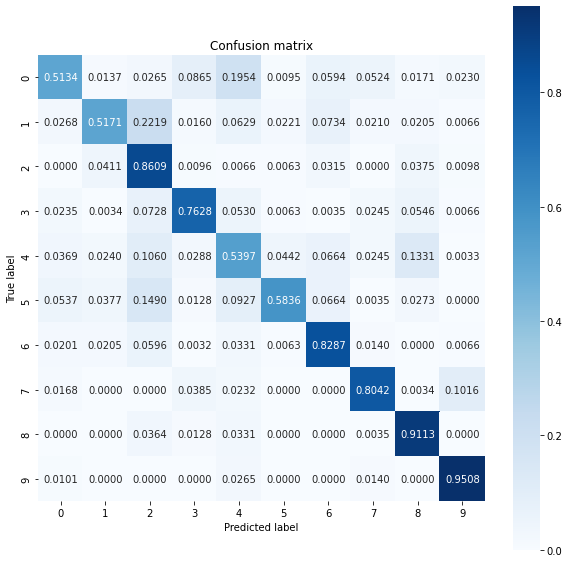

In [ ]:
show_confusion_matrix(Y_test,labels,prediction)

In [ ]:
# evaluate model on Test Set
test_loss, test_acc = model_cnn.evaluate(X_test, Y_test, verbose=2)
print('\nTest accuracy:', test_acc)

94/94 - 2s - loss: 1.3790 - accuracy: 0.7264 - 2s/epoch - 18ms/step

Test accuracy: 0.7263615131378174


## Recurrent Neural Network

La idea detras de esto era primero crear un autoencoder que aprendiera a representar segundos. posteriormente usar el encoder (representación en segundos) para aplicarle una convolución de un kernel de 3 de una dimensión para que se aprendiera lo que hay en un segundo anterior, el segundo actual y el segundo siguiente.


La primera complicación que vi fue que quería usar el audio en bruto sin ocupar espectrogramas o tff, pero estos eran muy grandes y en colab me gastaba toda la ram al quererlos guardar en un .json, asi que use espectrogramas y reuse los mfcc de cada audio. Lo bueno de los espectrogramas y el mfcc es que ya se tiene de forma mas clara el audio en función al tiempo, ya que esto se hace con los hop_length.


El mfcc shape es de $\left(\frac{d*sr}{hl}\times num\_mfcc\right)$, donde sr es en sample rate del audio, d la duración en seg del audio y hl es hop length. Justo por esto podemos partir mfcc en segmentos que corresponden a segundos. Y con esto se me hizo facil pensar en alimentar con esto una RNN.


Pero antes de eso hacer un encoder RNN que mande cada segmento de segundo a un valor que represente un segundo y esto ahora si mandarlo a algo que represente los datos como una relación entre segundo actual, anterior y siguiente.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

### Dataset

In [ ]:
data_path = path + "data_complete(1).json"

In [ ]:
def load_data(data_path):

    with open(data_path, "r") as f:
        data = json.load(f)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

In [ ]:
X, Y = load_data(data_path)

Data succesfully loaded!


### Pipeline

Aqui hago reshape de los datos a segementos que representan segundos.

In [ ]:
song_duration = 30
timesteps = song_duration
n_features = 43

In [ ]:
X.shape

(998, 1292, 1)

Elimino algunos segementos del audio para que se pueda partir en pedazos de segundos.

In [ ]:
X = np.delete(X,-1,1)
X.shape

(998, 1290, 1)

In [ ]:
X = np.reshape(X,(-1,song_duration,n_features))

In [ ]:
X.shape

(998, 30, 43)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [ ]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.2)

In [ ]:
X.shape

(998, 30, 43)

### Training

#### Encoder


Esta es la arquitectura de un autoencoder que codifica cada segmento en un segundo.

In [ ]:
encoder = keras.Sequential()
encoder.add(layers.LSTM(128, activation='relu', return_sequences=True))
encoder.add(layers.LSTM(64, activation='relu', return_sequences=True))
encoder.add(layers.LSTM(32, activation='relu', return_sequences=True))
encoder.add(layers.LSTM(16, activation='relu', return_sequences=True))
encoder.add(layers.LSTM(8, activation='relu', return_sequences=True))
encoder.add(layers.LSTM(timesteps, activation='relu', return_sequences=False))

decoder = keras.Sequential()
decoder.add(layers.RepeatVector(timesteps))
decoder.add(layers.LSTM(timesteps, activation='relu', return_sequences=True))
decoder.add(layers.LSTM(8, activation='relu', return_sequences=True))
decoder.add(layers.LSTM(16, activation='relu', return_sequences=True))
decoder.add(layers.LSTM(32, activation='relu', return_sequences=True))
decoder.add(layers.LSTM(64, activation='relu', return_sequences=True))
decoder.add(layers.LSTM(128, activation='relu', return_sequences=True))
decoder.add(layers.TimeDistributed(layers.Dense(n_features)))

model = keras.Sequential([encoder,decoder])
model.build(input_shape=(None,timesteps,n_features))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 30)                158504    
                                                                 
 sequential_7 (Sequential)   (None, 30, 43)            145635    
                                                                 
Total params: 304,139
Trainable params: 304,139
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 100
batch_size = 50
model.trainable = True
history = model.fit(x=X_train,y=X_train,
                    validation_data=(X_validation,X_validation),
                    batch_size=batch_size,shuffle=True,epochs=epochs)

In [ ]:
model.save("autoencoder.h5")

#### Clasifier

##### RNN

Arquitectura de la red clasificadora que hace uso del encoder del autoencoder y 
decoderRNN pasa de un vector de dimension (d) a un vector de dimnesion (d,1) y asi poder meterlo a una conv1D con kernel 3 para relacionar segundo actual, anterior y siguiente.

In [ ]:
encoder.trainable = True

decoderRNN = keras.Sequential([
    layers.RepeatVector(timesteps),
    layers.LSTM(timesteps, activation='relu', return_sequences=True),
    layers.LSTM(8, activation='relu', return_sequences=True),
    layers.LSTM(16, activation='relu', return_sequences=True),
    layers.LSTM(32, activation='relu', return_sequences=True),
    layers.LSTM(64, activation='relu', return_sequences=True),
    layers.LSTM(128, activation='relu', return_sequences=True),
    layers.TimeDistributed(layers.Dense(1))
])

modelCNN = keras.Sequential([
    keras.layers.Conv1D(16, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling1D(2, padding='same'),
    keras.layers.Conv1D(32, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling1D(2, padding='same'),
])

model_classifier = keras.Sequential([
    encoder,
    modelCNN,
    keras.layers.Flatten(),
    keras.layers.Dense(96,activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32,activation='sigmoid'),
    keras.layers.Dense(11,activation='softmax')
])

model_classifier.build(input_shape=(None,timesteps,n_features))

model_classifier.compile(loss='sparse_categorical_crossentropy', optimizer='Adagrad',metrics=['accuracy'])

In [ ]:
model_classifier.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 30)                158504    
                                                                 
 sequential_24 (Sequential)  (None, 30, 1)             140217    
                                                                 
 sequential_25 (Sequential)  (None, 8, 32)             1632      
                                                                 
 flatten_6 (Flatten)         (None, 256)               0         
                                                                 
 dense_33 (Dense)            (None, 96)                24672     
                                                                 
 dropout_12 (Dropout)        (None, 96)                0         
                                                                 
 dense_34 (Dense)            (None, 64)              

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=25, verbose=1, mode='auto')

In [ ]:
epochs = 50
batch_size = 50
history = model_classifier.fit(x=X_train,y=Y_train,
                     validation_data=(X_validation,Y_validation),
                     batch_size=batch_size,shuffle=True,
                     epochs=epochs,
                     callbacks=[early_stopping])

Epoch 1/50
12/12 [==============================] - 20s 458ms/step - loss: 2.9568 - accuracy: 0.0950 - val_loss: 2.6961 - val_accuracy: 0.1143
Epoch 2/50
12/12 [==============================] - 5s 388ms/step - loss: 2.9060 - accuracy: 0.0896 - val_loss: 2.6572 - val_accuracy: 0.1143
Epoch 3/50
12/12 [==============================] - 4s 339ms/step - loss: 2.8297 - accuracy: 0.0968 - val_loss: 2.6076 - val_accuracy: 0.1286
Epoch 4/50
12/12 [==============================] - 6s 431ms/step - loss: 2.7943 - accuracy: 0.1057 - val_loss: 2.5964 - val_accuracy: 0.1500
Epoch 5/50
12/12 [==============================] - 6s 506ms/step - loss: 2.7922 - accuracy: 0.1004 - val_loss: 2.5352 - val_accuracy: 0.1357
Epoch 6/50
12/12 [==============================] - 3s 286ms/step - loss: 2.7492 - accuracy: 0.0896 - val_loss: 2.5618 - val_accuracy: 0.1429
Epoch 7/50
12/12 [==============================] - 5s 465ms/step - loss: 2.7203 - accuracy: 0.0950 - val_loss: 2.4937 - val_accuracy: 0.1000
Epoch

### Results

Pues como se vio, fue bastante mediocre el modelo. Se me hace que fue debido a que ocupo de mala forma cada arquitectura y que todavía no entiendo del todo con que tipo de dato estoy trabajando, ya que es posible que con este tipo de datos no era adecuado para trabajar con este modelo.